In [1]:
from data_prep.data_prep import prepare_all_data
from training.training import prepare_model_data
from model import burglary_model
from utils.utils import single_out_last, setup_reproducibility
from pipeline import train_and_evaluate_model
model_tuple, occupation_mappings,ward_idx_map = prepare_all_data("../merged_data.parquet", "lsoa")

c:\MiniConda\envs\py311\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\MiniConda\envs\py311\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\MiniConda\envs\py311\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

In [2]:
device = setup_reproducibility(42)
print(f'Using device: {device}')
training_data, testing_data = single_out_last(model_tuple[0])

Using device: cuda


In [3]:

# model_tuple = (
#     model_tuple[0],
# ['Ethnic Group|BAME (%)', 'Car or van availability|No cars or vans in household (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|4', 'n_neighbors', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|3', 'Public Transport Accessibility Levels|% 0-1 (poor access)|Level3_65', 'Household Composition|% One person household', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6a', 'Ethnic Group|Asian/Asian British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|2', 'Ethnic Group|Black/African/Caribbean/Black British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6b', 'Car or van availability|1 car or van in household (%)', 'Ethnic Group|Other ethnic group (%)', 'Tenure|Owned with a mortgage or loan (%)', 'Car or van availability|2 cars or vans in household (%)'],
# ['Mid-year Population Estimates|All Ages', 'Mid-year Population Estimates|Aged 0-15', 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Mid-year Population Estimates|Aged 45-64', 'Employment Rank (where 1 is most deprived)', 'Income Rank (where 1 is most deprived)'],
# ["post_corona", "month_sin"],
# ['time_log'],
# ['lag_1'],
# ['lag1_diff_neighbors', 'lag1_mean_neighbors', 'lag_1_x_n_neighbors']
# )

In [4]:
# # Without interaction terms,
# # rmse          1.675789
# # mae           0.897979
# # crps          0.343265
to_include = [
    'Public Transport Accessibility Levels|Number of people in each PTAL level:|6b',
     'Ethnic Group|White (%)', 'Ethnic Group|Black/African/Caribbean/Black British (%)',
     'Household Composition|% Couple household with dependent children',
     'Household Composition|% One person household',
      'area',
     'Public Transport Accessibility Levels|Average Score|Level3_64',
     'Tenure|Social rented (%)', 'n_neighbors',
     'Mid-year Population Estimates|Aged 16-29',
     'Mid-year Population Estimates|Aged 0-15',
     'Mid-year Population Estimates|All Ages',
     'Barriers to Housing and Services Rank (where 1 is most deprived)',
]
model_tuple = (
    model_tuple[0],
    ['Public Transport Accessibility Levels|Number of people in each PTAL level:|6b',
     'Ethnic Group|White (%)', 'Ethnic Group|Black/African/Caribbean/Black British (%)',
     'Household Composition|% Couple household with dependent children',
     'Household Composition|% One person household',
      'area',
     'Public Transport Accessibility Levels|Average Score|Level3_64',
     'Tenure|Social rented (%)', 'n_neighbors',],
    ['Mid-year Population Estimates|Aged 16-29',
     'Mid-year Population Estimates|Aged 0-15',
     'Mid-year Population Estimates|All Ages',
     'Barriers to Housing and Services Rank (where 1 is most deprived)',
     *[
    elem
    for elem in model_tuple[0]
    if elem.endswith("_x_post_corona")
       and any(inc in elem for inc in to_include)
],
     ],
    ["during_corona", "post_corona", "month_sin"],
    ['time_log'],
    ['lag_1',],
    ['lag1_median_neighbors'],
)

In [5]:
# Without interaction terms,
# model_tuple = (
#     model_tuple[0],
#     ['Public Transport Accessibility Levels|Number of people in each PTAL level:|6b',
#      'Ethnic Group|White (%)', 'Ethnic Group|Black/African/Caribbean/Black British (%)',
#      'Household Composition|% Couple household with dependent children',
#      'Household Composition|% One person household',
#      'area',
#      'Public Transport Accessibility Levels|Average Score|Level3_64',
#      'Tenure|Social rented (%)', 'n_neighbors',],
#     ['Mid-year Population Estimates|Aged 16-29',
#      'Mid-year Population Estimates|Aged 0-15',
#      'Mid-year Population Estimates|All Ages',
#      'Barriers to Housing and Services Rank (where 1 is most deprived)',
#      *[elem for elem in model_tuple[0] if elem.endswith("_x_post_corona") or elem.endswith("_x_during_corona")]],
#     ["during_corona", "post_corona", "month_sin"],
#     ['time_log'],
#     ['lag_1',],
#     ['lag1_median_neighbors'],
# )
# model_tuple = (
#     model_tuple[0],
#     ['Public Transport Accessibility Levels|Number of people in each PTAL level:|6b',
#      'Ethnic Group|White (%)', 'Ethnic Group|Black/African/Caribbean/Black British (%)',
#      'Household Composition|% Couple household with dependent children',
#      'Household Composition|% One person household',
#      'area',
#      'Public Transport Accessibility Levels|Average Score|Level3_64',
#      'Tenure|Social rented (%)', 'n_neighbors',],
# ['Emergency locations_x_post_corona',
#  'Ethnic Group|White (%)_x_post_corona',
#  'Households|All households_x_post_corona',
#  'Household Composition|% One person household_x_post_corona',
#  'Tenure|Owned with a mortgage or loan (%)_x_post_corona',
#  'lag_1_x_post_corona',
#  'lag_3_x_post_corona',
#  r'Household Composition|% Lone parent household_x_post_corona',
#  'roll_3_mean_x_post_corona',
#  'Mid-year Population Estimates|Aged 0-15_x_post_corona',
#  'Car or van availability|Cars per household_x_post_corona',
#  'Income Rank (where 1 is most deprived)_x_post_corona',
#  'Health Deprivation and Disability Rank (where 1 is most deprived)_x_post_corona',
#  'Food locations_x_post_corona',
#  'Employment Rank (where 1 is most deprived)_x_post_corona',
#  'lag_4_x_post_corona',
#  'Mid-year Population Estimates|Aged 0-15',
#  'Dwelling type|Flat, maisonette or apartment (%)_x_post_corona',
#  'Mid-year Population Estimates|All Ages',
#  'Barriers to Housing and Services Rank (where 1 is most deprived)_x_post_corona',
#  'Parking locations_x_post_corona',
#  'Education, Skills and Training Rank (where 1 is most deprived)_x_post_corona'],
#     ["during_corona", "post_corona", "month_sin"],
#     ['time_log'],
#     ['lag_1',],
#     ['lag1_median_neighbors'],
# )
# model_tuple = (
#     model_tuple[0],
#     ['Public Transport Accessibility Levels|Number of people in each PTAL level:|6b',
#      'Ethnic Group|White (%)', 'Ethnic Group|Black/African/Caribbean/Black British (%)',
#      'Household Composition|% Couple household with dependent children',
#      'Household Composition|% One person household',
#      'area',
#      'Public Transport Accessibility Levels|Average Score|Level3_64',
#      'Tenure|Social rented (%)', 'n_neighbors',],
# ['Household Composition|% One person household_x_post_corona',
#  r'Household Composition|% Lone parent household_x_post_corona',
#  'Mid-year Population Estimates|Aged 0-15_x_post_corona',
#  'roll_3_mean_x_post_corona',
#  'Employment Rank (where 1 is most deprived)_x_post_corona',
#  'Income Rank (where 1 is most deprived)_x_post_corona',
#  'Tenure|Owned with a mortgage or loan (%)_x_post_corona',
#  'lag_4_x_post_corona',
#  'Car or van availability|Cars per household_x_post_corona',
#  'lag_1_x_post_corona',
#  'Food locations_x_post_corona'],
#     ["during_corona", "post_corona", "month_sin"],
#     ['time_log'],
#     ['lag_1',],
#     ['lag1_median_neighbors'],
# )

In [7]:
# # Without interaction terms,
# model_tuple = (
#     model_tuple[0],
#     ['Public Transport Accessibility Levels|Number of people in each PTAL level:|6b', 'Ethnic Group|White (%)', 'Ethnic Group|Black/African/Caribbean/Black British (%)', 'Household Composition|% Couple household with dependent children', 'Household Composition|% One person household', 'area', 'Public Transport Accessibility Levels|Average Score|Level3_64', 'Tenure|Social rented (%)', 'n_neighbors',],
#     ['Mid-year Population Estimates|Aged 16-29', 'Mid-year Population Estimates|Aged 0-15', 'Mid-year Population Estimates|All Ages', 'Barriers to Housing and Services Rank (where 1 is most deprived)', 'Education, Skills and Training Rank (where 1 is most deprived)'],
#     # ['Mid-year Population Estimates|All Ages', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Employment Rank (where 1 is most deprived)', 'Living Environment Rank (where 1 is most deprived)'],
#     ["during_corona", "post_corona", "month_sin"],
#     ['time_log'],
#     ['lag_1',],
#     ['lag1_median_neighbors'],
# )

In [8]:
# (['Car or van availability|Cars per household',
#   'Dwelling type|Flat, maisonette or apartment (%)',
#   'Education locations',
#   'Emergency locations',
#   'Entertainment locations',
#   'Ethnic Group|Asian/Asian British (%)',
#   'Ethnic Group|Black/African/Caribbean/Black British (%)',
#   'Ethnic Group|Mixed/multiple ethnic groups (%)',
#   'Ethnic Group|White (%)',
#   'Food locations',
#   'Household Composition|% Couple household with dependent children',
#   'Household Composition|% Couple household without dependent children',
#   'Household Composition|% Lone parent household',
#   'Household Composition|% One person household',
#   'Households|All households',
#   'Leisure locations',
#   'Parking locations',
#   'Public Transport Accessibility Levels|Average Score|Level3_64',
#   'Public Transport Accessibility Levels|Number of people in each PTAL level:|5',
#   'Public Transport Accessibility Levels|Number of people in each PTAL level:|6a',
#   'Public Transport Accessibility Levels|Number of people in each PTAL level:|6b',
#   'Public transport locations',
#   'Shopping locations',
#   'Tenure|Owned with a mortgage or loan (%)',
#   'Tenure|Private rented (%)',
#   'Tenure|Social rented (%)',
#   'area',
#   'n_neighbors'],
#  ['Barriers to Housing and Services Rank (where 1 is most deprived)',
#   'Education, Skills and Training Rank (where 1 is most deprived)',
#   'Employment Rank (where 1 is most deprived)',
#   'Health Deprivation and Disability Rank (where 1 is most deprived)',
#   'Income Rank (where 1 is most deprived)',
#   'Living Environment Rank (where 1 is most deprived)',
#   'Mid-year Population Estimates|Aged 0-15',],
#  ['during_corona', 'month_sin', 'post_corona'],
#  ['time_log'],
#  ['lag_1',
#   'lag_2',
#   'lag_3',
#   'lag_4',
#   'roll_12_mean',
#   'roll_3_mean',
#   'roll_6_mean'],
#  ['lag1_median_neighbors', 'lag1_sum_neighbors'])

In [9]:
train_data = prepare_model_data(training_data, *model_tuple[1:], device, ward_idx_map=ward_idx_map)
test_data = prepare_model_data(testing_data, *model_tuple[1:], device, train_data["means"], train_data["stds"], ward_idx_map)

evaluation_metrics, svi, svi.guide, prediction_tester = train_and_evaluate_model(train_data, test_data, burglary_model, occupation_mappings[1], testing_steps=5000)

Training SVI: 100%|██████████| 971/971 [02:53<00:00,  5.59it/s]


In [10]:
from pipeline import cross_validate_time_splits
results = cross_validate_time_splits(model_tuple, "time_s", 12, burglary_model,
                           occupation_mappings[1], device, ward_idx_map)
print(results[0].mean())
results[0]

Training SVI:   0%|          | 2/971 [00:38<5:13:36, 19.42s/it]


KeyboardInterrupt: 

# Explainability

In [11]:
# posterior predictive samples:   preds  (shape: [S, N])   – integers
# posterior rate samples:         lam    (shape: [S, N])   – reals
# design-matrix DataFrame:        X_df   (one row per LSOA month)
# original GeoJSON for LSOAs:     lsoa_geo
import geopandas as gpd
preds = prediction_tester.predictions["obs"].cpu().numpy()    # shape (1000, N)
lam   = prediction_tester.predictions["lam"].cpu().numpy()    # shape (1000, N)
X_df = testing_data.copy()
X_df["lsoa"] = X_df["occupation_idx"].map(occupation_mappings[1])
lsoa_geo = gpd.read_file("../processed_data/LSOA boundaries.geojson")

In [12]:
X_df["lsoa"]

171       E01000001
343       E01000002
515       E01000003
687       E01000005
859       E01000006
            ...    
853119    E01035688
853291    E01035689
853463    E01035690
853635    E01035691
853807    E01035692
Name: lsoa, Length: 4964, dtype: object

In [13]:
lsoa_geo = lsoa_geo[["LSOA21CD", "geometry"]].rename(columns={"LSOA21CD": "lsoa"}).copy()

In [14]:
X_df["burglaries"]

171       0.0
343       0.0
515       1.0
687       1.0
859       0.0
         ... 
853119    4.0
853291    0.0
853463    4.0
853635    0.0
853807    3.0
Name: burglaries, Length: 4964, dtype: float32

In [15]:
X_df[["occupation_idx", "burglaries"]].assign(lsoa=X_df["occupation_idx"].map(occupation_mappings[1])).set_index("lsoa")[["burglaries"]]

,burglaries
lsoa,
E01000001,0.0
E01000002,0.0
E01000003,1.0
E01000005,1.0
E01000006,0.0
...,...
E01035688,4.0
E01035689,0.0
E01035690,4.0


In [ ]:
prediction_tester.get_median_predictions()

,median
E01000001,0.0
E01000002,0.0
E01000003,0.0
E01000005,2.0
E01000006,0.0
...,...
E01035688,2.0
E01035689,0.0
E01035690,3.0
E01035691,2.0


: 

In [16]:
prediction_tester.get_confidence_intervals(0.05)

,lower_bound,upper_bound
E01000001,0.0,2.0
E01000002,0.0,2.0
E01000003,0.0,2.0
E01000005,0.0,6.0
E01000006,0.0,2.0
...,...,...
E01035688,0.0,5.0
E01035689,0.0,3.0
E01035690,0.0,8.0
E01035691,0.0,6.0


In [17]:
prediction_tester.get_confidence_intervals(0.05).reset_index(names="lsoa")

,lsoa,lower_bound,upper_bound
0,E01000001,0.0,2.0
1,E01000002,0.0,2.0
2,E01000003,0.0,2.0
3,E01000005,0.0,6.0
4,E01000006,0.0,2.0
...,...,...,...
4959,E01035688,0.0,5.0
4960,E01035689,0.0,3.0
4961,E01035690,0.0,8.0
4962,E01035691,0.0,6.0


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume you already have:
#   ci_df       : DataFrame with columns ["lsoa", "lower_bound", "upper_bound"]
#   summary_df  : DataFrame with columns ["lsoa", "burglaries_observed"] (and possibly other cols)
summary_df = X_df[["occupation_idx", "burglaries"]].assign(lsoa=X_df["occupation_idx"].map(occupation_mappings[1])).set_index("lsoa")[["burglaries"]].reset_index()

In [36]:
import numpy as np
alphas = np.arange(0.05, 1, 0.05)
coverages = []
confidence_intervals = []
for alpha in alphas:
    ci_df = prediction_tester.get_confidence_intervals(alpha).reset_index(names="lsoa")
    test = ci_df.merge(summary_df, on="lsoa", how="left")
    test["contained"] = (test["lower_bound"] <= test["burglaries"]) &  (test["burglaries"] <= test["upper_bound"])
    coverages.append(test["contained"].mean() * 100)
    confidence_intervals.append((test["upper_bound"] - test["lower_bound"]).mean())

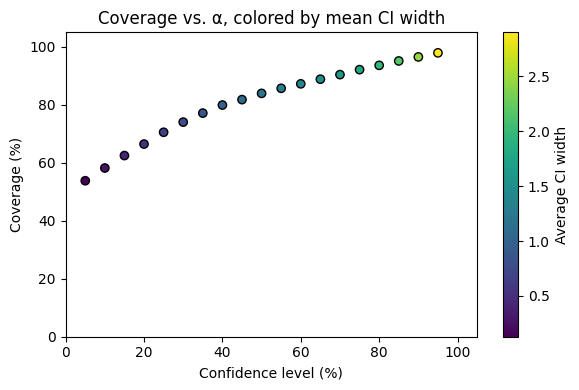

In [37]:
import numpy as np
import matplotlib.pyplot as plt

confidence = (1 - alphas) * 100  
# 2. Scatter plot: alpha vs coverage, colored by mean CI width
fig, ax = plt.subplots(figsize=(6, 4))
sc = ax.scatter(confidence, coverages, c=confidence_intervals, cmap='viridis', edgecolor='k')
ax.set_xlabel("Confidence level (%)")
ax.set_ylabel("Coverage (%)")
ax.set_title("Coverage vs. α, colored by mean CI width")
ax.set_xlim(0, 105)
ax.set_ylim(0, 105)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Average CI width")
plt.tight_layout()
plt.show()


In [58]:
import plotly.graph_objects as go


fig = go.Figure(
    layout=dict(
        template="plotly_dark",              # built-in dark template :contentReference[oaicite:2]{index=2}
        width=800,
        height=600,
    ),
    data=go.Scatter(
    x=confidence_intervals,
    y=coverages,
    mode="markers",
    marker=dict(
        size=8,
        color=confidence,
        colorscale="ylorrd",
        colorbar=dict(title="Average confidence level (%)")
    )
))

fig.update_layout(
    title="Coverage of true burglaries given CI intervals",
    xaxis=dict(title="Average CI width"),
    yaxis=dict(title="Coverage (%)", range=[0, 100])
)

fig.update_coloraxes(
    colorbar_title_side="bottom",   # move the colorbar title to the right side :contentReference[oaicite:0]{index=0}
    colorbar_title_text="Average confidence level (%)",
)

fig.show()


In [ ]:
from testing.testing import StatisticalTester
factors_map ={
    "b_static": model_tuple[1],
    "b_dynamic": model_tuple[2],
    "b_seasonal": model_tuple[3],
    "b_time_tr": model_tuple[4],
    "b_temporal": model_tuple[5],
    "b_spatial": model_tuple[6],
}
statistical_tester = StatisticalTester(test_data, burglary_model, svi.guide, factors_map)

In [ ]:
statistical_tester.predict(5000)

In [ ]:
alpha_1 = 0.05
frames = statistical_tester.evaluate_all(alpha=alpha_1)

In [ ]:
frames['b_static']

In [ ]:
for frame in frames.values():
    print(frame)

In [ ]:
# for key, frame in frames.items():
#     print(frame.query("significant_CI == 'Yes'")["col"])
#     print()

frames["b_dynamic"].query("significant_CI == 'Yes'")["col"].to_list()
# frames["b_dynamic"].query("significant_CI == 'Yes'")["col"]
# frames["b_seasonal"].query("significant_CI == 'Yes'")["col"]
# frames["b_time_tr"].query("significant_CI == 'Yes'")["col"]
# frames["b_temporal"].query("significant_CI == 'Yes'")["col"]
# frames["b_spatial"].query("significant_CI == 'Yes'")["col"]


In [ ]:
import plotly.graph_objects as go

# Loop through each DataFrame in frames and create a dark‐themed Plotly figure
for alpha, df in frames.items():
    # 1. Compute error bar magnitudes
    lower_err = df['mean'] - df['ci_lower']
    upper_err = df['ci_upper'] - df['mean']
    contains_zero = (df['ci_lower'] <= 0) & (df['ci_upper'] >= 0)

    # 2. Initialize figure with dark theme
    fig = go.Figure(layout=dict(
        template="plotly_dark",              # built-in dark template :contentReference[oaicite:2]{index=2}
        paper_bgcolor="black",               # full black canvas :contentReference[oaicite:3]{index=3}
        plot_bgcolor="black",                # black plotting area
    ))

    # 3a. Plot intervals excluding zero (blue markers)
    fig.add_trace(go.Scatter(
        x=df.loc[~contains_zero, 'mean'],
        y=df.loc[~contains_zero, 'col'],
        error_x=dict(
            type='data',
            symmetric=False,
            array=upper_err[~contains_zero],
            arrayminus=lower_err[~contains_zero],
            thickness=2,
            width=5
        ),
        mode='markers',
        marker=dict(color='cyan', size=8),  # brighter marker for contrast
        name='CI excludes 0'
    ))

    # 3b. Plot intervals including zero (orange markers)
    fig.add_trace(go.Scatter(
        x=df.loc[contains_zero, 'mean'],
        y=df.loc[contains_zero, 'col'],
        error_x=dict(
            type='data',
            symmetric=False,
            array=upper_err[contains_zero],
            arrayminus=lower_err[contains_zero],
            thickness=2,
            width=5
        ),
        mode='markers',
        marker=dict(color='orange', size=8),
        name='CI includes 0'
    ))

    # 4. Vertical zero reference line in white
    fig.add_shape(
        type="line",
        x0=0, x1=0,
        y0=-0.5, y1=len(df)-0.5,
        xref="x", yref="y",
        line=dict(color="white", dash="dash", width=2)
    )

    # 5. Layout and axes adjustments
    fig.update_layout(
        title=f'Sample of Posterior Coefficients ({(1-alpha_1)*100:.1f}% CI)',
        xaxis_title=f'Coefficient estimate ± {(1-alpha_1)*100:.1f}% CI',
        yaxis_title='Feature',
        width=1200,
        height=300 + 25 * len(df),
        margin=dict(l=150, r=50, t=100, b=50),
        legend=dict(bgcolor='rgba(0,0,0,0)'),  # transparent legend background
    )

    # 6. Preserve DataFrame order on the y‐axis (inverted)
    fig.update_yaxes(
        categoryorder='array',
        categoryarray=df['col'].tolist()[::-1]
    )

    fig.show()


In [ ]:
model_tuple[0].columns

In [ ]:
# model_tuple[0]["Mid-year Population Estimates|All Ages"].value_counts()

In [ ]:
y_obs = prediction_tester.get_median_predictions().values              # 1-D arraylike of observed burglaries for the target month (length = n_lsoa)
posterior_samples = prediction_tester.predictions["obs"].cpu().numpy()  # 2-D ndarray (n_draws × n_lsoa) from pyro.infer.Predictive(...)
X = model_tuple[0].copy()                  # pandas DataFrame of feature values used at prediction time (n_lsoa × p)
# geo_lsoa =           # GeoDataFrame with an identical index, WGS84 geometry, and an "lsoa_code" column


In [ ]:
# # Cell 2 – Calibration Curve
# import pandas as pd
# from scipy.stats import percentileofscore

# quantiles = np.arange(5, 100, 5)           # 5 % steps
# coverage  = []

# for q in quantiles:
#     q_lo = np.percentile(y_rep, 50 - q/2, axis=0)
#     q_hi = np.percentile(y_rep, 50 + q/2, axis=0)
#     inside = (y_obs >= q_lo) & (y_obs <= q_hi)
#     coverage.append(inside.mean())         # proportion actually covered

# fig, ax = plt.subplots()
# ax.plot(quantiles/100, coverage, marker="o", label="Model")
# ax.plot([0,1], [0,1], "--", label="Ideal")
# ax.set_xlabel("Posterior interval nominal level")
# ax.set_ylabel("Observed coverage")
# ax.set_title("Calibration / Reliability Diagram")
# ax.legend()
# plt.show()


In [ ]:
# filter the DataFrame
percent_zero = (
    model_tuple[0]['burglaries'].eq(0)
      .groupby(model_tuple[0]['time_s'])
      .transform('mean')
      .mul(100).round(2)
)
percent_zero

In [ ]:
model_tuple[1:]

In [ ]:
corr = model_tuple[0].corr().abs()
labels_trunc = [f"  {col[:20]}  " for col in corr.columns]

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

# 2) Truncate labels to first 15 characters

# 3) Create the interactive heatmap with the dark template
fig = px.imshow(
    corr.values.round(2),
    x=labels_trunc,
    y=labels_trunc,
    color_continuous_scale="Viridis",    # colorblind-friendly
    zmin=0,
    zmax=1,
    aspect="equal",                      # square cells
    template="plotly_dark",              # ← use the dark theme :contentReference[oaicite:0]{index=0}
    # title="Feature Correlation Heatmap"
)

# 4) Show every 5th tick to prevent overlap
n = len(labels_trunc)
step = 5
fig.update_xaxes(
    tickmode="array",
    tickvals=list(range(0, n, step)),
    ticktext=[labels_trunc[i] for i in range(0, n, step)],
    tickangle=90
)
fig.update_yaxes(
    tickmode="array",
    tickvals=list(range(0, n, step)),
    ticktext=[labels_trunc[i] for i in range(0, n, step)],
    autorange="reversed",
)

# 5) (Optional) Force the plot background to true black for maximum contrast
fig.update_layout(
    paper_bgcolor="black",
    plot_bgcolor="black",
    coloraxis_colorbar=dict(
        thickness=15,
        title="Correlation"
    ),
    width=600,
    height=600,
    margin=dict(l=0, r=0, t=0, b=0)
)

fig.show()

In [ ]:
import pandas as pd
import numpy as np

# 1. Compute the absolute correlation matrix

# 2. Zero out the lower triangle and the diagonal
#    so we only inspect each pair once, and drop self‐correlations
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
upper = corr.where(mask)

# 3. “Unpivot” to a long form and filter
high_corr = (
    upper
    .stack()                             # turns into a Series indexed by (feature1, feature2)
    .reset_index()                       # DataFrame with columns ['level_0','level_1', 0]
    .rename(columns={'level_0':'feature1','level_1':'feature2', 0:'correlation'})
    .query('correlation > 0.9')         # keep only those above 0.9
    .sort_values('correlation', ascending=False)
    .reset_index(drop=True)
)

In [ ]:
high_corr

In [ ]:
df = pd.read_parquet("../merged_data.parquet")

In [ ]:
percent_zero = (
    df['Burglaries amount'].eq(0)
      .groupby(df['date'])
      .transform('mean')
      .mul(100).round(2)
)

In [ ]:
df_plot = (
    df.assign(zero=df['Burglaries amount'].eq(0))
      .groupby('date')['zero']
      .mean()
      .mul(100)
      .round(2)
      .reset_index(name='percent_zero')
)


fig = go.Figure(layout=dict(
        template="plotly_dark",              # built-in dark template :contentReference[oaicite:2]{index=2}
        paper_bgcolor="black",               # full black canvas :contentReference[oaicite:3]{index=3}
        plot_bgcolor="black",                # black plotting area
    ))

fig.add_trace(go.Scatter(
    x=df_plot["date"],
    y=df_plot["percent_zero"],
    mode='lines',
    name='Zero %',
    line=dict(width=2)
))

fig.update_layout(
    title='Monthly Percentage of LSOAs with Zero Burglaries',
    template='plotly_dark',           # apply the dark theme :contentReference[oaicite:6]{index=6}
    xaxis=dict(title='Date', tickangle=45),
    yaxis=dict(title='Percentage of Zero-Burglary LSOAs (%)', range=[0, 60]),
    width=1000,
    height=700,
)

fig.show()

In [ ]:
df.groupby("date")["Burglaries amount"].sum().plot()

In [ ]:
import plotly.graph_objects as go
import pandas as pd
from plotly.colors import qualitative

# Replace this with your actual DataFrame
crime_df = df.copy()  

# 1. Monthly burglary totals
monthly = crime_df.groupby("date")["Burglaries amount"].sum().reset_index()
monthly["date"] = pd.to_datetime(monthly["date"])

# 2. Key event periods
events = [
    {"Event": "2012 Olympics",        "Start": "2012-05-27", "End": "2012-10-12"},
    {"Event": "Brexit Referendum",    "Start": "2016-05-23", "End": "2016-07-23"},
    {"Event": "Knife Crime Peak",     "Start": "2017-01-01", "End": "2018-12-31"},
    {"Event": "COVID Lockdowns",      "Start": "2020-01-23", "End": "2021-06-30"},
    {"Event": "Post-Pandemic Surge",  "Start": "2021-06-30", "End": "2023-12-31"},
]
for ev in events:
    ev["Start"] = pd.to_datetime(ev["Start"])
    ev["End"]   = pd.to_datetime(ev["End"])

# 3. Assign each event a distinct color
palette = qualitative.Plotly  # has at least 10 distinct colors
colors = {ev["Event"]: palette[i % len(palette)] for i, ev in enumerate(events)}

# 4. Build figure

fig = go.Figure(layout=dict(
        template="plotly_dark",              # built-in dark template :contentReference[oaicite:2]{index=2}
        paper_bgcolor="black",               # full black canvas :contentReference[oaicite:3]{index=3}
        plot_bgcolor="black",                # black plotting area
    ))

for ev in events:
    color = colors[ev["Event"]]
    # shaded band
    fig.add_shape(
        type="rect",
        x0=ev["Start"], x1=ev["End"],
        y0=0, y1=1,
        xref="x", yref="paper",
        fillcolor=color,
        opacity=0.15,
        line_width=0
    )
    # centered label above the band
    fig.add_annotation(
        x=ev["Start"] + (ev["End"] - ev["Start"]) / 2,
        y=1.05,
        xref="x", yref="paper",
        text=ev["Event"],
        showarrow=False,
        font=dict(color=color, size=14, family="Arial"),
        align="center"
    )

# 5. Add burglary time series
fig.add_trace(go.Scatter(
    x=monthly["date"],
    y=monthly["Burglaries amount"],
    mode="lines",
    name="Monthly Burglaries",
    line=dict(color="lime", width=2)
))

# 6. Layout tweaks
fig.update_layout(
    template="plotly_dark",
    title="Monthly Burglaries with Key Events Overlay",
    xaxis_title="Date",
    yaxis_title="Number of Burglaries",
    width=1500,
    height=600,
    margin=dict(l=80, r=20, t=100, b=50),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)

fig.show()
